In [1]:
#imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
pd.options.mode.chained_assignment = None  # default='warn'


#read in the dataset we scraped from Elite Prospects
df = pd.read_csv('C:/Users/tdavi/Documents/Concordia Bootcamps/hockey_final_project/hockey_data.csv')

#when we created the dataframe saved it and now loaded it back in, a new index was asigned to the df which is fine
#we will the old index as well as the player category as the information is already in seperate columns (playername and position)
df.drop(['Unnamed: 0', 'player'], axis=1, inplace=True)

#looking at the data every name in the dataset has a trailing whitespace which is extremely annoying to deal with so we'll fix that
df['playername'] = df['playername'].str.strip()

#then we'll need to remove accents on certain names we need to replace them with the regular variant
df['playername'] = df['playername'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

#convert our column with numeric data to actual numbers instead of objects so we can preform calculations on them
df[['gp', 'g', 'a', 'tp', 'ppg', 'pim', '+/-']] = df[['gp', 'g', 'a', 'tp', 'ppg', 'pim', '+/-']].apply(pd.to_numeric, errors='coerce')

#fill all nans with 0s as the data is still important these players potentially are ltir types of players or they never actually played but were listed as avaliable
df.fillna(0, inplace=True)

#now going to convert columns that should be ints back to int as all column where converted to floats
df[['gp', 'g', 'a', 'tp', 'pim', '+/-']] = df[['gp', 'g', 'a', 'tp', 'pim', '+/-']].astype(int)

#create new column for goals per game, assists per game, penalty minutes per game and plus minus per game to better classify what type of player the individual is
#a player with a significantly higher goals per game than as assists per game would make that player a better scorer or more efficient
#using per game averages is significantly better than raw totals as a player who is elite maybe have had a season ending injury
#half way through the season
#pro rating stats is common for the analytics communities
df['gpg'] =  df['g']/df['gp'].replace({0 : np.inf})
df['apg'] =  df['a']/df['gp'].replace({0 : np.inf})
df['pmpg'] =  df['pim']/df['gp'].replace({0 : np.inf})
df['+/-pg'] =  df['+/-']/df['gp'].replace({0 : np.inf})


#create a new df that will contain the features that we would like to pass to the model
df_model = df[['gp', 'tp', 'ppg', 'gpg', 'apg', 'pmpg', '+/-pg', 'season', 'playername', 'link', 'position']]

#create a primary position for all players so we can reduce the amount of-
#-columns created from pd.get_dummies, the first letter is the primary position the player-
#-played that season so taking position 0 works fine in this case
df_model['position'] = df_model['position'].str[0]

#i would like to enncode our position column to and pass it into the model
#some players played multiple postitions like position_f stands for forward and position_w stands for wing so this could potentially cause issues however that remains to be seen
df_model = pd.get_dummies(df_model, columns=['position'])
df_model

,gp,tp,ppg,gpg,apg,pmpg,+/-pg,season,playername,link,position_C,position_D,position_F,position_L,position_R,position_W
0,17,32,1.88,1.294118,0.588235,2.352941,0.000000,1918-1919,Newsy Lalonde,https://www.eliteprospects.com/player/23540/ne...,1,0,0,0,0,0
1,18,28,1.56,1.055556,0.500000,1.666667,0.000000,1918-1919,Frank Nighbor,https://www.eliteprospects.com/player/24049/fr...,1,0,0,0,0,0
2,18,27,1.50,1.166667,0.333333,1.666667,0.000000,1918-1919,Odie Cleghorn,https://www.eliteprospects.com/player/189452/o...,0,0,0,0,1,0
3,18,24,1.33,1.000000,0.333333,3.055556,0.000000,1918-1919,Cy Denneny,https://www.eliteprospects.com/player/23973/cy...,0,0,0,1,0,0
4,17,19,1.12,0.823529,0.294118,0.882353,0.000000,1918-1919,Didier Pitre,https://www.eliteprospects.com/player/122581/d...,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45190,18,0,0.00,0.000000,0.000000,0.111111,-0.277778,2021-2022,Mikhail Maltsev,https://www.eliteprospects.com/player/312218/m...,0,0,0,1,0,0
45191,24,0,0.00,0.000000,0.000000,3.208333,-0.250000,2021-2022,Mason Geertsen,https://www.eliteprospects.com/player/64567/ma...,0,1,0,0,0,0
45192,0,0,0.00,0.000000,0.000000,0.000000,0.000000,2021-2022,Fredrik Karlstrom,https://www.eliteprospects.com/player/220059/f...,1,0,0,0,0,0
45193,0,0,0.00,0.000000,0.000000,0.000000,0.000000,2021-2022,Zach Senyshyn,https://www.eliteprospects.com/player/245108/z...,0,0,0,0,1,0


In [2]:
#create KNN to find closest compareable player given sum of career stats
from sklearn.neighbors import NearestNeighbors
import pickle

#create a new df for the KNN
df_knn = df_model.drop(['season', 'link'], axis=1)

#create a groupby aggregating all the stats to get career averages
group = df_knn.groupby('playername').agg({'gp': ['sum'], 'tp': ['sum'], 'ppg': ['mean'], 'gpg': ['mean'],
                                    'apg': ['mean'], 'pmpg': ['mean'], '+/-pg': ['mean'],
                                    'position_C': ['mean'], 'position_D': ['mean'], 'position_F': ['mean'], 
                                    'position_L': ['mean'], 'position_R': ['mean'], 'position_W': ['mean']})

#drop column level 1 which is the mean and sum as we have an multiindex and it's a bit of a pain to work with it
group.columns = group.columns.droplevel(1)

#create a nearest neighbours for our dataset and fit it
nn= NearestNeighbors(radius=0.5, algorithm='auto')
KNN_model = nn.fit(group)

#create function to return our closest compareable player along with their stats which is pulled directly from the knn_dataframe
def compareable(dataset, model, player):

    #get the closest compareable player for our asked about player
    comparable = model.kneighbors([dataset.loc[player,:]], 2, False)

    #convert array to list which is the index in our group dataframe of which player is closest to them
    comparable = list(comparable[0])

    return dataset.iloc[comparable]

#this will return a dataframe with our asked player and the closest compareable player to them
cc_results = compareable(group, KNN_model, 'Nikolaj Ehlers')
cc_results

,gp,tp,ppg,gpg,apg,pmpg,+/-pg,position_C,position_D,position_F,position_L,position_R,position_W
playername,,,,,,,,,,,,,
Nikolaj Ehlers,472,354,0.764286,0.352684,0.410614,0.339600,0.151271,0.0,0.0,0.0,1.0,0.0,0
Jonathan Marchessault,474,358,0.631111,0.309553,0.322187,0.406347,0.056864,0.0,0.0,0.0,1.0,0.0,0


In [48]:
#create an LSTM to predict the ppg for their next season if they were to play for each player that has played in the league
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

#create function to groupby the data to extract the last three seasons for each player will we need at least 3 seasons for each player to predict
#if the data doesn't exist we won't be able to generate an accurate preditction for tthat player creating artifical data for them would not be accurate and creates bias
#for this to work we need to assume that the season beforethe one that we want to predict will be what their results would be this allows us to create a prediction every player that is eligible
#via the above criteria, I didn't want to do a games played restriction as games from before the expansion teams came only had like 20 games a season versus 82 games now
def players(df, seasons):

    #group the data so that we have two rows for every player to predict from
    grouped = df.sort_values(by=['playername', 'season']).groupby('link', dropna=False).tail(seasons)

    #filter the data if we don't have three rows we've got an issue predicting so we'll need to exclude those players unfortunately as it throws the prediction off pretty bad
    counts = grouped['link'].value_counts()
    filtered_data = grouped[~grouped['link'].isin(counts[counts < seasons].index)]
    
    filtered_data

    return filtered_data

#get the grouped data with players that have played more than 3 seasons
grouped_data = players(df_model, 3)

#drop the season, playername and link columns as we know our data is in the correct format to create lags from it
final_df = grouped_data.drop(['season', 'playername', 'link'], axis=1)

#reorder columns to isolate ppg at the end of the dataframe
final_df = final_df[['gp','tp','gpg','apg','pmpg','+/-pg','position_C','position_D','position_F','position_L','position_R','position_W','ppg']]

In [50]:
#this will reshape df into the shape we need to pass into the lstm
#dim one is the recorded stats of a player for 3 seasons there are shape[0] / 3 records for each player as there are 3 seasons for each player
#dim two is the number of lags which would be three as we are predicting from three previous seasons, when we predict we will use the last season in their career to assume the ppg of the next season if they were to play it
#dim three is the number of total features

def shape_data(df, lags):
    shape_of_dataset = df.shape

    #create dimensions force int otherwise reshape will throw error
    dim1 = int(shape_of_dataset[0] / lags)
    dim2 = int(lags)
    dim3 = int(shape_of_dataset[1])

    #reshape and remove value we want to predict for which is ppg which is in position [13] -1 will start from but not include
    reshaped = np.array(df).reshape((dim1, dim2, dim3))

    #remove ppg from indpendants 
    x = reshaped[:,:,:-1]

    #remove our responding variable ppg from the reshaped data
    y = reshaped[:,:,-1]

    return x , y

def scale_data(train, test):

    #inintalize min max scaler
    scaler = MinMaxScaler()
    
    #because the data is in a 3d shape we need to reshape it to 2D form which is what MinMaxscaler expects to transform the data
    #we add another reshape afterwards to reshape the dataset back to the original 3D shape we had before transformation
    #fit_transform the x_train data
    train = scaler.fit_transform(train.reshape(-1, train.shape[-1])).reshape(train.shape)

    #fit transform the x_test data
    test = scaler.transform(test.reshape(-1, test.shape[-1])).reshape(test.shape)

    return train, test


#create x and y for train test split
x, y = shape_data(final_df, 3)

#create our train test split for the data
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.85, random_state=20)

#scale the data using min max scaler
x_train, x_test = scale_data(x_train, x_test)

In [51]:
#create our LSTM NN hockey model to predict points per game
model = Sequential()
model.add(LSTM(12, input_shape=(3, 12), return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

model.summary()


#Use mean squared error to determine how effective the model is at predicting our ppg and the standard adam optimizer
model.compile(loss='mean_squared_error', optimizer='adam')


#fit our data to the model
model_history = model.fit(x_train, y_train, epochs=20, validation_data=(x_test, y_test), shuffle=False)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 12)                1200      
                                                                 
 dropout_8 (Dropout)         (None, 12)                0         
                                                                 
 dense_11 (Dense)            (None, 1)                 13        
                                                                 
Total params: 1,213
Trainable params: 1,213
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
135/135 [==============================] - 2s 7ms/step - loss: 0.0567 - val_loss: 0.0465
Epoch 2/20
135/135 [==============================] - 0s 4ms/step - loss: 0.0454 - val_loss: 0.0377
Epoch 3/20
135/135 [==============================] - 1s 4ms/step - loss: 0.0366 - val_loss: 0.0291
Epoch 4/20
135/1

In [52]:
from keras.models import load_model
#save the model to be used for deployment with flask
#save our model with keras 
model.save('Hockey_LSTM_Model')

LSTM_model = load_model('Hockey_LSTM_Model')

INFO:tensorflow:Assets written to: Hockey_LSTM_Model\assets


INFO:tensorflow:Assets written to: Hockey_LSTM_Model\assets


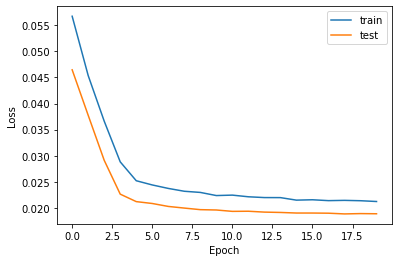

In [53]:
#plot the loss of our model
plt.plot(model_history.history['loss'], label='train')
plt.plot(model_history.history['val_loss'], label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [54]:
#we need to grab the players who have played at least 3 seasons in the NHL
#we need to grab the last season to make a prediction from that point, so the season after that whatever that may be
#we'll just call the players function twice first getting all the eligible players like we did the first time then the resulting df returned will be passed-
#this time with seasons = 1 which will grab the last row for each player
#reset the index as well
#load our LSTM_Hockey_Model in using keras

def predict(df, lstm_model):
    eligible_players = players(df, 3).reset_index(drop=True)
    
    #drop the columns we don't want
    player_data_to_predict = eligible_players.drop(['season', 'playername', 'link'], axis=1)

    #reorder the columns so we can isolate ppg easier
    player_data_to_predict = player_data_to_predict[['gp','tp','gpg','apg','pmpg','+/-pg','position_C','position_D','position_F','position_L','position_R','position_W','ppg']]

    #now we need to reshape the data
    player_data_to_predict_x, player_data_to_predict_y = shape_data(player_data_to_predict, 3)

    #now we scale the data
    #inintalize min max scaler
    mm_scaler = MinMaxScaler()
    
    #because the data is in a 3d shape we need to reshape it to 2D form which is what MinMaxscaler expects to transform the data
    #we add another reshape afterwards to reshape the dataset back to the original 3D shape we had before transformation
    #fit_transform the x_train data
    train = mm_scaler.fit_transform(x_train.reshape(-1, x_train.shape[-1])).reshape(x_train.shape)

    scaled_x = mm_scaler.transform(player_data_to_predict_x.reshape(-1, player_data_to_predict_x.shape[-1])).reshape(player_data_to_predict_x.shape)

    #get our ppg predictions
    ppg_results = lstm_model.predict(scaled_x)

    #create empty table with 12 fields matching our features without responding variable
    trainPredict_dataset_like = np.zeros(shape=(len(player_data_to_predict_x), 12))
    #put the predicted values in the right field
    trainPredict_dataset_like[:,0] = ppg_results[:,0]
    #inverse transform and then select the right field
    results = mm_scaler.inverse_transform(trainPredict_dataset_like)[:,0]

    return results, eligible_players



In [55]:
#grab the last row for each of the eligible players careers and reset the index
#create function
def get_result(data, lstm_model, player):
    
    results, eligible_players = predict(data, lstm_model)

    last_season = players(eligible_players, 1).reset_index(drop=True)

    #add the results to the df
    last_season['LSTM_predicted_next_season_ppg'] = results

    #grab only information we would like to see
    last_season = last_season[['playername', 'link', 'ppg', 'LSTM_predicted_next_season_ppg']]

    #rename ppg to current season ppg, and link to Elite prospects link
    last_season.rename(columns={'ppg':'current_season_ppg', 'link':'elite_prospects_link'}, inplace=True)
    result = last_season.loc[last_season['playername']==player]

    return result

In [69]:
result = get_result(df_model, LSTM_model, 'Auston Matthews')

result

,playername,elite_prospects_link,current_season_ppg,LSTM_predicted_next_season_ppg
310,Auston Matthews,https://www.eliteprospects.com/player/199898/a...,1.46,1.456016
